### Project Explanation

#### In the given data, which includes x-ray images of patients and divides them to 3 classes; <br>
* Normal Patient <br>
* Patient with Viral Pneumonia <br>
* Patient with Covid <br> <br>

The project goal is to process this given data and find the optimum deep learning model with CNN algorithm for classifying the patients 

### Importing required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### Listing the GPUs and Checking If There Is Any Error Related to GPU

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "No GPU hardware device found!"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
print("GPU: ", physical_devices[0])

GPU:  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [1]:
"""
DATA_DIR is the location the data in
Categories is the classes
x is x-ray images
y is class list(0 = Normal, 1 = Viral Pneumonia, 2 = Covid)
"""

DATA_DIR = "D:\AI_Data\COVID"
CATEGORIES = ["Normal", "Viral_Pneumonia", "Covid"]
x = []
y = []

# Pre-processing

### Processing The Data 

In [4]:
for category in CATEGORIES:
    categoryPath = os.path.join(DATA_DIR, category) # The directory is named same with categories, so when we us os.path.join function -->
    for img in os.listdir(categoryPath):            # --> it will directly go to data directory
        newArray = cv2.imread(os.path.join(categoryPath, img), cv2.IMREAD_GRAYSCALE) # reaching to each image and reading as grayscale to use less memory
        newArray = cv2.resize(newArray, (75, 75))  # Converting the images pixels to 75x75 to use less memory, thus, faster processing
        
        x.append(newArray)      # Appending the image to list x
        y.append(CATEGORIES.index(category)) # Appending the image's category to list y

In [5]:
# Converting the lists to Numpy arrays
x = np.array(x)
y = np.array(y)

In [13]:
x.shape   # 15153 photos with 75x75 pixels

(15153, 75, 75)

### Displaying images from classes

Normal Patient


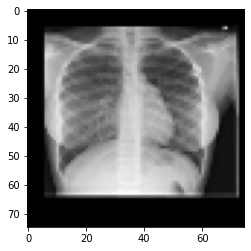


Patient with Viral Pneumonia


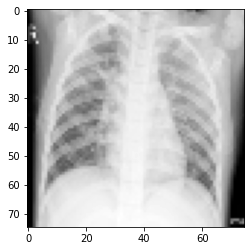


Patient with Covid


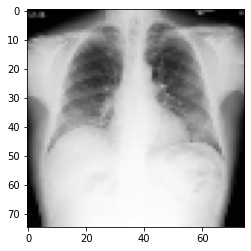

In [28]:
print("Normal Patient")
plt.imshow(x[0], cmap = "gray")
plt.show()
print("\nPatient with Viral Pneumonia")
plt.imshow(x[11000], cmap = "gray")
plt.show()
print("\nPatient with Covid")
plt.imshow(x[14000], cmap = "gray")
plt.show()

### Normalizing

In [10]:
x = x / 255  

### Splitting The Data to Train and Test

In [11]:
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.25, random_state = 0)  # 75% train, 25% test data

In [14]:
# Data distribution after the split
print("Train Data: {} images\nTest Data: {} images".format(len(xTrain), len(xTest)))

Train Data: 11364 images
Test Data: 3789 images


### Vectorization

In [12]:
xTrain = xTrain.reshape(-1, 75, 75, 1)
xTest = xTest.reshape(-1, 75, 75, 1)
yTrain = yTrain.reshape(-1,)
yTest = yTest.reshape(-1,)

# Training

### Creating The CNN Model

In [55]:
earlyStopping = EarlyStopping(monitor = "val_loss", mode = "min", verbose = 1, patience = 4, restore_best_weights = True)
# I add earlystopping to my model to have better and stable results

In [56]:
model = Sequential([
    Conv2D(256, kernel_size = (3,3), activation = "relu", input_shape= (75, 75, 1)),
    MaxPooling2D(pool_size = (2,2)),
    
    Conv2D(128, kernel_size = (3,3), activation = "relu"),
    MaxPooling2D(pool_size = (2,2)),
    
    Conv2D(64, kernel_size = (3,3), activation = "relu"),
    MaxPooling2D(pool_size = (2,2)),
    
    Flatten(),
    Dense(32),
    Dense(3, activation = "softmax")
])

model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
model.optimizer.learning_rate = 0.0005

### Training the model

In [57]:
model.fit(x = xTrain, y = yTrain, epochs = 11, validation_data = (xTest, yTest), verbose = 1, callbacks = [earlyStopping])

Epoch 1/11
356/356 [==============================] - 22s 60ms/step - loss: 0.6499 - accuracy: 0.7220 - val_loss: 0.6083 - val_accuracy: 0.7189
Epoch 2/11
356/356 [==============================] - 21s 59ms/step - loss: 0.3907 - accuracy: 0.8337 - val_loss: 0.3376 - val_accuracy: 0.8662
Epoch 3/11
356/356 [==============================] - 21s 59ms/step - loss: 0.3172 - accuracy: 0.8676 - val_loss: 0.2834 - val_accuracy: 0.8831
Epoch 4/11
356/356 [==============================] - 21s 59ms/step - loss: 0.2472 - accuracy: 0.8969 - val_loss: 0.2419 - val_accuracy: 0.9026
Epoch 5/11
356/356 [==============================] - 21s 59ms/step - loss: 0.2154 - accuracy: 0.9150 - val_loss: 0.2544 - val_accuracy: 0.8979
Epoch 6/11
356/356 [==============================] - 21s 59ms/step - loss: 0.1973 - accuracy: 0.9220 - val_loss: 0.1921 - val_accuracy: 0.9301
Epoch 7/11
356/356 [==============================] - 21s 59ms/step - loss: 0.1614 - accuracy: 0.9366 - val_loss: 0.2109 - val_accuracy:

# Analysis

### Loss-ValLoss Graph

In [58]:
historyData = pd.DataFrame(model.history.history)  # Let's take the model's history data to see loss-valLoss graph

<AxesSubplot:>

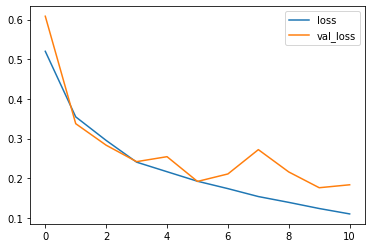

In [59]:
historyData[["loss", "val_loss"]].plot() 

### Making Predictions and Evaluating The Results

In [69]:
predictions = model.predict(xTest)

correctPrediction = 0
wrongPrediction = 0

In [70]:
for i in range(len(predictions)): 
    prediction = np.argmax(predictions[i]) # the prediction the model makes (Selecting the highest probability)
    correctAnswer = yTest[i]               # the class the image belongs to (True y)
    
    if (prediction == correctAnswer):      # If the prediction is correct
        correctPrediction += 1
    else:                                  # If the prediction is wrong
        wrongPrediction += 1

print("Correct prediction amount: {}\nWrong prediction amount: {}\nAccuracy of the model: {}%".format(correctPrediction, wrongPrediction, (round(100*(1.0-(wrongPrediction/correctPrediction)), 1))))    

Correct prediction amount: 3550
Wrong prediction amount: 239
Accuracy of the model: 93.3%


### Model Evaluation with Data Visualization

In [60]:
# Let's write a function that plots a confusion matrix with heatmap

def confMatrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(
        cm,
        index = ["Normal", "Viral_Pneumonia", "Covid"],
        columns = ["Normal", "Viral_Pneumonia", "Covid"])
    
    sns.heatmap(cm_df, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()

In [72]:
# We have y_test argument for confMatrix() function, since our predictions list consits of probabilities(softmax activation function) of each classes for every sample,
# We will use numpy.argmax() function, which selects the max element from the given list
# Finally, we will insert the predictions to the new list and pass it as an argument to the confMatrix() function 

predictedClasses = []

for i in range(len(predictions)):
    prediction = np.argmax(predictions[i]) # Pick the max value(probability)
    predictedClasses.append(prediction)    # Insert it to new list

predictedClasses = np.array(predictedClasses) # Convert the list to numpy array

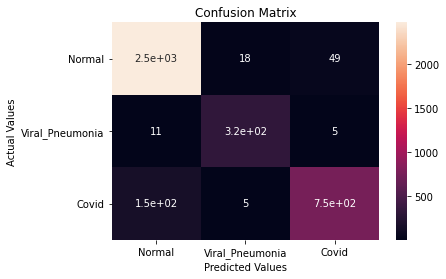

In [73]:
confMatrix(yTest, predictedClasses)

### Conclusion

####
According to Confusion Matrix, we can see that: <br>
* 18 healthy(Normal) patients are predicted as Viral_Pneumonia,  49 healthy  patients are predicted as Covid<br>
* 11 patients with Viral_Pneumonia are predicted as Normal, 5 patients with Viral_Pneumonia are predicted as Covid <br>
* 150 patients with covid are predicted as Normal, 5 patients with covid are predicted as Viral_Pneumonia <br> 

Since predicting someone healthy  as a Viral_Pnomonia or Covid is not risky for society, we can ignore it <br>
But, predicting someone who is Viral_Pneumonia or Covid as a healthy  person is a problem for society. <br>

As we can see from the statistics, predicting covid patients as normal patient is high compared to other classes's false predictions
Let's take a look to classification report to see exact % of accuracy for predicting covid patients correct

In [78]:
print(classification_report(yTest, predictedClasses))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      2545
           1       0.93      0.95      0.94       336
           2       0.93      0.83      0.88       908

    accuracy                           0.94      3789
   macro avg       0.93      0.92      0.93      3789
weighted avg       0.94      0.94      0.94      3789



####
Regarding the previous outputs, we should focus on recall score since it's important for False Negative (Predicting Covid patient as Normal patient) <br> <br>
While Recall score is high for Normal and Viral_Pneumonia, It's low for Covid. <br>


### Saving the model

In [79]:
model.save("acc.0.93")    # Saves the model in the directory where this .ipynb file exists

INFO:tensorflow:Assets written to: acc.0.93\assets


In [81]:
# If we want to load the model later without training it from 0, we can use load_model function

from tensorflow.keras.models import load_model
modelX = load_model("acc.0.93")  # Loads the model in the directory where this .ipynb file exists